Import all the libraries that are necessary 

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from skimage.feature import hog
from sklearn import svm
import cv2
from PIL import Image
from tqdm import tqdm
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import zipfile
import os
import ntpath
from os.path import isfile, isdir
from urllib.request import urlretrieve
%matplotlib inline

In [2]:
# Create an output directory in case it does not exist
if not os.path.exists("output_images"):
    os.makedirs("output_images")


The following is the code to download and extract the training data if it is not on the current system.

In [3]:
car = "vehicles.zip"
noncar = "non-vehicles.zip"

carpath = "car"
noncarpath = "noncar"

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile(car):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='Car data') as pbar:
        urlretrieve(
            'https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/vehicles.zip',
            car,
            pbar.hook)
if not isfile(noncar):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='Non-car data') as pbar:
        urlretrieve(
            'https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/non-vehicles.zip',
            noncar,
            pbar.hook)

if not isdir(carpath):
    zipcar = zipfile.ZipFile(car, 'r')
    zipcar.extractall(carpath)
    zipcar.close()
    
if not isdir(noncarpath):
    zipnoncar = zipfile.ZipFile(noncar, 'r')
    zipnoncar.extractall(noncarpath)
    zipnoncar.close()
    


Now we have the training data on our computer, we need to read them and put them onto a python list to identify rather they are cars or non-cars. The following code do exactly this. But for now, the following only read the name of the image files and then randomize them.

In [4]:
import glob
from random import shuffle

def ReadImages(car_imgs, carlist):
    for car_img in car_imgs:
        carlist.append(car_img)

cars = []
notcars = []

car_images = glob.glob('car/vehicles/GTI_Far/*.png')
ReadImages(car_images, cars)
car_images = glob.glob('car/vehicles/GTI_Left/*.png')
ReadImages(car_images, cars)
car_images = glob.glob('car/vehicles/GTI_MiddleClose/*.png')
ReadImages(car_images, cars)
car_images = glob.glob('car/vehicles/GTI_Right/*.png')
ReadImages(car_images, cars)
car_images = glob.glob('car/vehicles/KITTI_extracted/*.png')
ReadImages(car_images, cars)


car_images = glob.glob('noncar/non-vehicles/GTI/*.png')
ReadImages(car_images, notcars)
car_images = glob.glob('noncar/non-vehicles/Extras/*.png')
ReadImages(car_images, notcars)

shuffle(cars)
shuffle(notcars)


The following defined three functions: namely, bin_spatial, get_hog_features, and extract_features.

bin_spatial:

This is used as reading the image color contents or to read the spatial features. If the "size" input is None (by default), then it is used as reading the image color contents. Otherwise, it will be used as binary spatial function.

get_hog_features:

Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images. I provided the default inputs for orient, pix_per_cell, cell_per_block, and vis.

extract_features:

This function, basically read a list of image names, and then read the actual content of the images, and extract the spatial and Histogram of Oriented Gradients features. 

I did not use the color histogram because the impact for the classifier is very small that it does not contribute to important car detection decision. Especially when we are on the road where there is shadow from the tree or bad lighting condition.

In [5]:
from skimage.feature import hog

def bin_spatial(img, color_space='RGB', size=None):
    # Convert image to new color space (if specified)
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: 
        feature_image = np.copy(img)
            # Use cv2.resize().ravel() to create the feature vector
    if size != None:
        features = cv2.resize(feature_image, size).ravel()
    else:
        features = feature_image
    # Return the feature vector
    return features

def get_hog_features(img, orient = 9, pix_per_cell = 8, cell_per_block = 2, vis=False):    
    if vis == True:
        features, hog_img = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                   cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                   visualise=True, feature_vector=False)
        return features, hog_img
    else:
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                   cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                   visualise=False, feature_vector=True)
        return features

def extract_features(imgs, color_space='RGB', hog_channel='ALL'):
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        feature_image = bin_spatial(image, color_space=color_space)
        
        spatial_features = bin_spatial(feature_image, color_space='RGB', size=(32, 32))

        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel]))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel])
                    
        # Append the new feature vector to the features list
        features.append(np.concatenate((spatial_features, hog_features)))
    # Return list of feature vectors
    return features

To view our sample size for both car and non-car data. To generalize better, we will make the sample size the same for car and non-car data for training.

In [6]:
sample_size = min(len(cars),len(notcars))
print(sample_size)

8792


The following ocde is used to train our model with SVM (support vector machine). Since the features is from both the HOG and image spatial features, we normalize the feature vector with StandardScalar() function. the variables, svc, X_scaler are used later for our prediction.

In [7]:
import time

cars = cars[0:sample_size]
notcars = notcars[0:sample_size]

train_channel=2
t=time.time()
car_features = extract_features(cars, hog_channel=train_channel)
notcar_features = extract_features(notcars, hog_channel=train_channel)

t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract images Spatial and HOG features...')
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')

# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))


/Users/hiuchan/anaconda/envs/tensorflow/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


24.01 Seconds to extract images Spatial and HOG features...
Feature vector length: 4836
13.24 Seconds to train SVC...
Test Accuracy of SVC =  0.9713


Sliding windows function:

This function do sliding windows on the image capture from the camera so that we can do prediction. The size of the area to slide in the image is by default a 64 x 64 square.

In [162]:
def slide_window(img, x_start_stop=[None, None], y_start_stop=[360, 680], 
                    xy_window=(64, 64), xy_overlap=(0.75, 0.75)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list


In [163]:
# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

In [164]:
# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images

def single_img_features(img, color_space='RGB', hog_channel='ALL'):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    feature_image = bin_spatial(img, color_space=color_space)
    #3) Compute spatial features
    spatial_features = bin_spatial(feature_image, color_space='RGB', size=(32, 32))    
    #4) Append features to list
    img_features.append(spatial_features)
    
    #5) Compute histogram features
    if hog_channel == 'ALL':
        hog_features = []
        for channel in range(feature_image.shape[2]):
            hog_features.extend(get_hog_features(feature_image[:,:,channel])) 
    else:
        hog_features = get_hog_features(feature_image[:,:,hog_channel])
    
    #8) Append features to list
    img_features.append(hog_features)
    #9) Return concatenated array of features
    return np.concatenate(img_features)

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', hog_channel='ALL'):
    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, hog_channel=hog_channel)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows
    

In [165]:
def add_heat(heatmap, bbox_list):
    for box in bbox_list:
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold = 2):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

In [166]:
from scipy.ndimage.measurements import label

def findcar(image, svc, X_scaler, threshold=2, with_heat=False, heat=None, vis = False):
    h = np.zeros_like(image[:,:,0]).astype(np.float)

    draw_image = np.copy(image)
    image = image.astype(np.float32)/255

    # the following parameter seem to be the best value for now
    windows = slide_window(image, xy_window=(64, 64), xy_overlap=(0.75, 0.75))
    hot_windows = search_windows(image, windows, svc, X_scaler, hog_channel = 2)                       

    h = add_heat(h, hot_windows)
    
    # Apply threshold to help remove false positives
    if with_heat:
        h = apply_threshold(h+heat, threshold)
    else:
        h = apply_threshold(h, threshold)
    
    # Visualize the heatmap when displaying    
    heatmap = np.clip(h, 0, 255)
    
    if vis:
        plt.imshow(heatmap)
    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    output_img = draw_labeled_bboxes(draw_image, labels)
    return heatmap, output_img


/Users/hiuchan/anaconda/envs/tensorflow/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


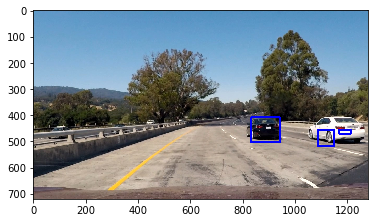

In [167]:
detectcar = mpimg.imread('test_images/test1.jpg')
h, output_img = findcar(detectcar, svc, X_scaler, threshold=2)
plt.imshow(output_img)

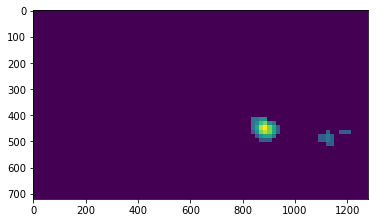

In [168]:
plt.imshow(h)

/Users/hiuchan/anaconda/envs/tensorflow/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


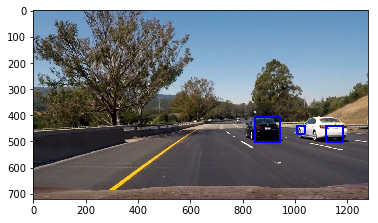

In [169]:
detectcar = mpimg.imread('test_images/test6.jpg')
h, output_img = findcar(detectcar, svc, X_scaler, threshold=2)
plt.imshow(output_img)

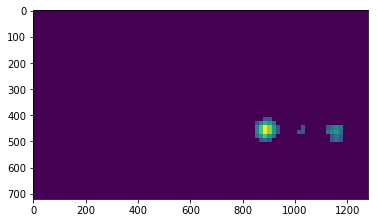

In [170]:
plt.imshow(h)

/Users/hiuchan/anaconda/envs/tensorflow/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


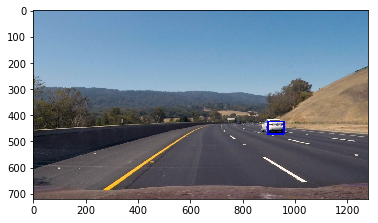

In [173]:
detectcar = mpimg.imread('test_images/test3.jpg')
h, output_img = findcar(detectcar, svc, X_scaler, threshold=2)
plt.imshow(output_img)

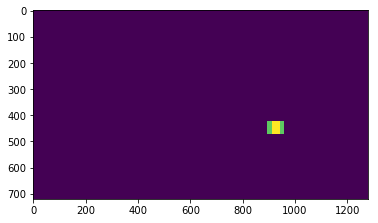

In [174]:
plt.imshow(h)

In [31]:
# Import everything needed to edit/save/watch video clips
import imageio
imageio.plugins.ffmpeg.download()
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [35]:
def process_image(img):
    if len(process_image.heat_map) == 0:
        process_image.map=np.zeros_like(img[:,:,0]).astype(np.float)
    
    h, output_img = findcar(img, svc, X_scaler, threshold=process_image.buffer*2, with_heat=True, heat=process_image.map)#process_image.buffer-2)
#    h, output_img = findcar(img, svc, X_scaler, threshold=process_image.buffer+1)
    process_image.heat_map.append(h)
    process_image.map += h
    if len(process_image.heat_map) >= process_image.buffer:
        process_image.map -= process_image.heat_map[0]
        del(process_image.heat_map[0])
    
    return output_img

process_image.buffer=5
process_image.heat_map=[]
process_image.map=None

In [37]:
if not os.path.exists("test_videos_output"):
    os.makedirs("test_videos_output")
    
project_output = 'test_videos_output/project_video.mp4'
clip1 = VideoFileClip("project_video.mp4")
project_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time project_clip.write_videofile(project_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/project_video.mp4
[MoviePy] Writing video test_videos_output/project_video.mp4



 12%|█▏        | 152/1261 [03:38<26:37,  1.44s/it]


 24%|██▍       | 303/1261 [07:14<23:01,  1.44s/it]


 36%|███▌      | 454/1261 [10:51<19:17,  1.43s/it]


 48%|████▊     | 605/1261 [14:28<15:49,  1.45s/it]


 60%|█████▉    | 756/1261 [18:05<12:10,  1.45s/it]


 72%|███████▏  | 907/1261 [21:42<08:28,  1.44s/it]


 84%|████████▍ | 1057/1261 [25:19<04:49,  1.42s/it]


 96%|█████████▌| 1205/1261 [28:51<01:20,  1.43s/it]


100%|█████████▉| 1260/1261 [30:10<00:01,  1.44s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/project_video.mp4 

CPU times: user 30min 1s, sys: 6.79 s, total: 30min 8s
Wall time: 30min 11s


In [38]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_output))